# REVISE
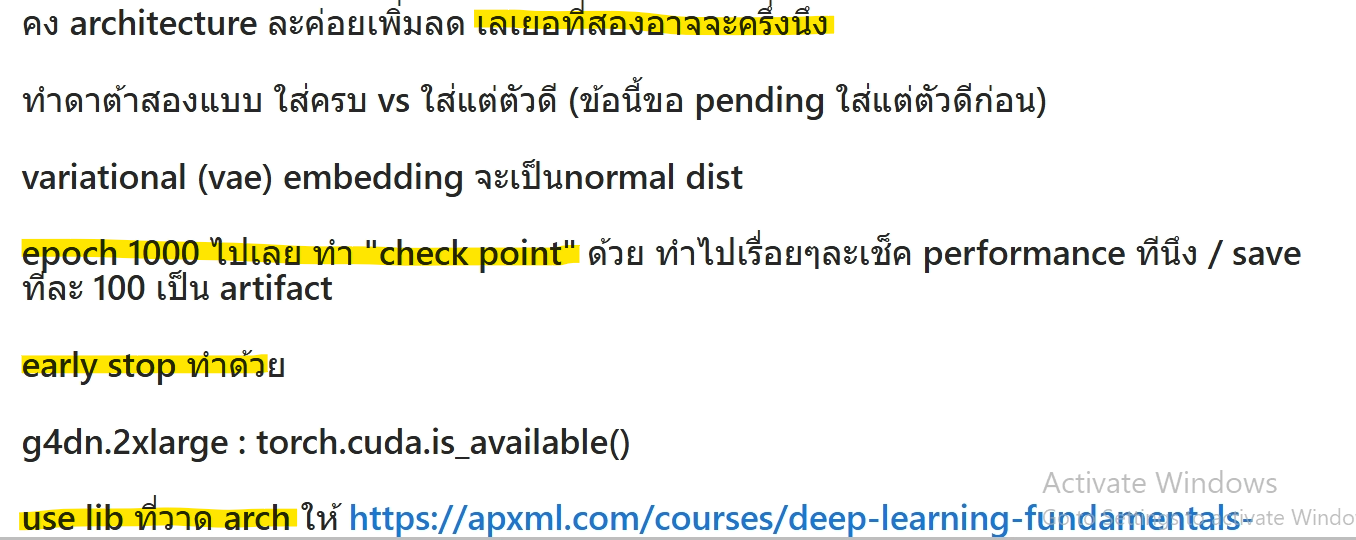

# [done 21082025] plotly 3d , 2d(tsne shrink), select loss fn, pipeline (main)

## [future work] : VAE, อธิบายการนำเสนอ , เก็บ checkpoint แล้ว แต่ตอนนี้ยังไม่ได้เก็บ hyperparameter ในแต่ละครั้งที่จูน

# Read Library

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install tqdm

In [3]:
# !pip install torchview

In [4]:
# !pip install torchinfo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
from scipy import stats
import warnings
import re
import datetime
from package.utils import profile_data ,DotDict, timer, get_config, load_data, merge_data 

In [3]:
from package.model_deep_ae import (set_seed,
                                generate_mock_data,
                                expand_rule_columns,
                                subset_by_timeunit,
                                split_train_test,
                                prepare_train_val_test_data,
                                Autoencoder,
                                # train_autoencoder,
                                save_checkpoint,
                                load_checkpoint     ,
                                train_autoencoder_checkpoint     ,
                                load_pickled_autoencoder     ,
                                plot_learning_curve,
                                get_reconstruction_error,
                                plot_threshold_vs_metric_percentile,
                                flag_anomalies,
                                detect_anomalies,
                                tune_autoencoder_grid,
                                extract_embeddings,
                                plot_latent_space_2d,
                                plot_latent_space_3d,
                                create_pack_results,
                                append_experiment_results,
                                )

from package.model_deep_ae import (evaluate_fraud_predictions,
                                evaluate_thresholds,
                                run_training_pipeline,
                                run_threshold_and_plot_pipeline
                                )

# Read Data

In [4]:
mock1 = generate_mock_data(n_sales=10000, n_rules=10, fraud_ratio=0.05, seed=42)
mock1

function: generate_mock_data is starting...
function: generate_mock_data successfully executed at 1.7599215507507324s


,sales_id,timeunit,flag_fraud,rule_1,rule_2,rule_3,rule_4,rule_5,rule_6,rule_7,rule_8,rule_9,rule_10
0,0,l3,0,-1.487862,-1.125186,0.388819,-1.173873,1.112634,-0.071120,0.085595,-0.278373,0.772848,0.783160
1,1,l3,1,4.182238,3.601215,2.665470,2.039528,3.012423,6.067259,3.677239,3.582941,2.306755,1.086816
2,2,l3,0,0.608267,1.345935,-0.174648,1.360168,-0.189693,0.849585,-2.218570,2.418778,1.495458,-0.284626
3,3,l3,0,-1.972089,0.288028,-1.443926,0.444854,0.411566,-0.941403,1.120967,0.805575,0.975823,0.008858
4,4,l3,0,-1.415524,0.977872,-0.270371,-1.389780,1.352039,2.099408,-0.041248,2.159121,0.091315,-0.380456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9995,l36,0,0.647493,-0.163831,-1.743780,1.184970,-0.193500,-1.273190,0.773532,-1.803990,2.209333,-0.800634
59996,9996,l36,0,-0.716390,1.700367,-0.933375,0.191027,-1.348096,2.584121,-0.054343,-1.355835,1.124099,0.609250
59997,9997,l36,0,1.066770,-1.592284,-1.706892,1.178747,0.985029,0.364593,-2.039914,-0.325981,0.478952,0.808948
59998,9998,l36,0,1.622065,-0.303766,1.377932,-0.777375,-0.179569,0.607243,-1.106324,-0.591367,0.501293,0.450664


# Autoencoder

- Autoencoder คือ neural network ที่เรียนรู้จะ compress ข้อมูล (encode) แล้ว reconstruct ข้อมูลเดิม (decode) ให้ใกล้เคียงที่สุด
- Encoder → บีบข้อมูลจาก input ขนาดใหญ่เป็น latent space ขนาดเล็ก
- Latent space → ข้อมูลสรุปที่มีมิติเล็กลง (เรียกว่า embedding)
- Decoder → แปลง latent space กลับเป็น input เดิม
- OBJ: เรียนรู้โครงสร้างหรือ pattern ของข้อมูลปกติ

https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_7_DeepLearning/Autoencoders.html

https://www.sciencedirect.com/science/article/pii/S1877050920306840?via%3Dihub

**Application to detect fraud**
- Train autoencoder กับข้อมูลปกติ **[TUNE#1 Architecture]** and **[TUNE#2 Select Features]**
- Predict: ให้ model reconstruct ข้อมูล test
- คำนวณ reconstruction error using MSE โดย ถ้า error สูง → anomaly / fraud <br>
    Normal data → model reconstruct ได้ดี → error ต่ำ <br>
    Anomaly / novel data → model reconstruct ไม่ดี → error สูง <br>
    จึงต้องมีการ **[TUNE#3 Threshold]**

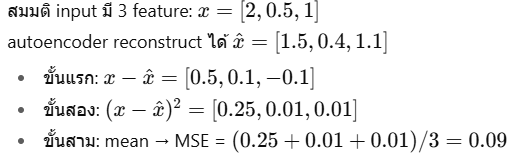

https://www.softnix.co.th/2020/03/24/anomaly-detection-part-5-autoencoder/

## Novelty Detection

### Prep data

In [5]:
df_transformed = expand_rule_columns(mock1)
df_transformed

function: expand_rule_columns is starting...
function: expand_rule_columns successfully executed at 0.4349970817565918s


,sales_id,flag_fraud,rule_10_l12,rule_10_l24,rule_10_l3,rule_10_l36,rule_10_l6,rule_10_l9,rule_1_l12,rule_1_l24,...,rule_8_l3,rule_8_l36,rule_8_l6,rule_8_l9,rule_9_l12,rule_9_l24,rule_9_l3,rule_9_l36,rule_9_l6,rule_9_l9
0,0,0,-0.943490,0.000232,0.783160,0.668797,0.960825,0.888457,-0.389376,0.583561,...,-0.278373,2.053579,0.455672,-0.069470,0.495704,0.001691,0.772848,1.665550,0.385248,-0.944372
1,1,1,4.692913,4.551202,1.086816,3.403392,5.183808,1.615426,2.214356,-0.011207,...,3.582941,-0.468026,2.011123,3.757316,2.700979,-0.738528,2.306755,0.177472,3.777520,3.757815
2,2,0,-0.090432,0.162957,-0.284626,1.460788,0.862283,0.239878,-0.033178,0.214724,...,2.418778,-0.601681,0.202997,2.124338,2.314027,-0.759213,1.495458,-0.912673,-0.432277,-0.981344
3,3,0,-0.474335,-0.921535,0.008858,0.198231,0.106144,-0.716708,-0.282492,-0.336470,...,0.805575,0.768310,-1.021580,-1.304657,0.012273,-2.042267,0.975823,1.258121,-0.668648,0.743399
4,4,0,0.216357,0.160711,-0.380456,-0.865218,0.443058,0.023325,-1.395400,-0.888219,...,2.159121,-0.920259,0.253299,0.587801,-0.308097,-0.009286,0.091315,-1.773001,0.756075,-0.458285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0,0.375382,-1.835668,-0.044578,-0.800634,-0.630433,-0.276283,2.580578,-1.781299,...,0.135087,-1.803990,0.191417,0.677831,1.198868,-0.298484,-0.032698,2.209333,0.449176,-0.458590
9996,9996,0,0.345934,-1.321427,-2.077919,0.609250,0.135422,0.709128,-0.499775,-0.600470,...,0.136357,-1.355835,0.836549,-1.048457,0.901520,0.958509,0.467324,1.124099,-0.847919,-1.218175
9997,9997,0,-0.185466,-0.474796,-0.171683,0.808948,0.278778,1.366620,-1.171032,0.312918,...,-0.874977,-0.325981,0.455277,1.512830,-0.218674,-0.583616,-0.052822,0.478952,-2.058627,0.809383
9998,9998,0,-0.992855,1.335352,-0.272822,0.450664,0.403903,0.112418,-0.819924,-0.590858,...,-0.698919,-0.591367,0.020615,-0.224661,0.135384,0.522100,-0.929514,0.501293,-0.439973,-1.102105


In [6]:
df_subset = subset_by_timeunit(df_transformed, ["l3"])
df_subset

function: subset_by_timeunit is starting...
function: subset_by_timeunit successfully executed at 0.0012810230255126953s


,sales_id,flag_fraud,rule_10_l3,rule_1_l3,rule_2_l3,rule_3_l3,rule_4_l3,rule_5_l3,rule_6_l3,rule_7_l3,rule_8_l3,rule_9_l3
0,0,0,0.783160,-1.487862,-1.125186,0.388819,-1.173873,1.112634,-0.071120,0.085595,-0.278373,0.772848
1,1,1,1.086816,4.182238,3.601215,2.665470,2.039528,3.012423,6.067259,3.677239,3.582941,2.306755
2,2,0,-0.284626,0.608267,1.345935,-0.174648,1.360168,-0.189693,0.849585,-2.218570,2.418778,1.495458
3,3,0,0.008858,-1.972089,0.288028,-1.443926,0.444854,0.411566,-0.941403,1.120967,0.805575,0.975823
4,4,0,-0.380456,-1.415524,0.977872,-0.270371,-1.389780,1.352039,2.099408,-0.041248,2.159121,0.091315
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0,-0.044578,-1.529631,1.238310,-0.532892,0.190398,0.422554,-0.023546,-1.133380,0.135087,-0.032698
9996,9996,0,-2.077919,-0.229829,0.674063,1.617860,1.771565,0.757900,0.673849,-1.540880,0.136357,0.467324
9997,9997,0,-0.171683,1.911644,-0.083414,-0.863277,-1.034273,0.248429,0.416630,1.336392,-0.874977,-0.052822
9998,9998,0,-0.272822,-0.438518,-0.747820,1.957480,0.877297,0.099010,0.422686,0.969281,-0.698919,-0.929514


In [7]:
# train_all_df, test_df = split_train_test(df_subset)
train_all_df, test_df = split_train_test(df_transformed)

function: split_train_test is starting...
function: split_train_test successfully executed at 0.013998031616210938s


In [8]:
train_all_df

,sales_id,flag_fraud,rule_10_l12,rule_10_l24,rule_10_l3,rule_10_l36,rule_10_l6,rule_10_l9,rule_1_l12,rule_1_l24,...,rule_8_l3,rule_8_l36,rule_8_l6,rule_8_l9,rule_9_l12,rule_9_l24,rule_9_l3,rule_9_l36,rule_9_l6,rule_9_l9
0,3630,0,0.065061,-1.381646,-0.234773,0.741172,0.099183,0.366599,-0.140290,3.381064,...,-0.053467,-0.768867,-0.343623,1.127276,0.415893,-1.760683,-0.160935,-1.078442,-0.200519,-0.737941
1,5986,0,2.076734,-1.698424,1.327322,-1.492183,-0.431614,-0.267538,1.257328,0.740960,...,0.520798,-0.472491,-0.362397,-0.171599,-0.929991,0.203863,0.309667,-0.146252,-0.238942,-0.603972
2,7036,0,-0.004042,-0.765742,0.363375,-0.764716,-1.135618,0.203589,-1.628004,1.779344,...,0.813936,-0.131309,0.100068,0.529787,0.476450,-1.479328,1.154796,0.141447,-1.795989,-0.375962
3,628,0,0.541729,0.577937,-0.483484,-0.293931,-0.206698,-0.700038,-0.186508,-0.025391,...,-0.011590,-0.515937,0.858287,0.661098,0.083020,0.091615,0.566057,-1.089515,0.105609,0.094998
4,6352,0,0.441966,-0.143543,-0.107302,0.072213,1.529024,-0.451931,1.627444,-1.060203,...,-0.777887,1.115271,0.325433,-0.223382,-0.738602,0.741632,1.069188,-0.947983,-0.355904,1.024567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,9252,0,0.622077,0.322945,-1.774210,-1.054220,-0.054596,-0.274055,0.949006,-0.434668,...,1.045306,0.688933,-1.274707,1.347434,-0.497313,-0.092631,0.319269,-1.195080,-1.479523,-2.051548
7996,5428,0,1.041514,-0.225759,-1.243773,-0.627989,0.622732,0.362270,0.944345,-0.257786,...,1.349662,-0.732960,-1.422959,0.718340,-1.428343,0.287439,-0.831471,0.175511,1.361890,-0.779703
7997,5860,0,-0.296280,1.274017,0.055937,-0.428108,-0.530243,1.672888,-1.188514,-0.131148,...,-0.768976,0.604696,-0.560844,-1.026435,0.872974,-0.822784,0.960491,-0.175414,-1.221068,0.355948
7998,5684,0,-0.377596,1.074399,0.245012,-0.380907,0.532185,0.595630,0.877931,-0.102435,...,-1.319686,0.711382,-0.070824,0.152201,-1.890995,-0.893135,1.778506,0.439911,1.323151,-0.535564


In [9]:
train_all_df['flag_fraud'].value_counts()

flag_fraud
0    7621
1     379
Name: count, dtype: int64

In [10]:
train_all_df['flag_fraud'].value_counts(normalize=True)

flag_fraud
0    0.952625
1    0.047375
Name: proportion, dtype: float64

In [11]:
test_df

,sales_id,flag_fraud,rule_10_l12,rule_10_l24,rule_10_l3,rule_10_l36,rule_10_l6,rule_10_l9,rule_1_l12,rule_1_l24,...,rule_8_l3,rule_8_l36,rule_8_l6,rule_8_l9,rule_9_l12,rule_9_l24,rule_9_l3,rule_9_l36,rule_9_l6,rule_9_l9
0,8751,0,-0.315800,-0.936668,-0.014066,0.375657,0.651100,-1.467959,-2.458383,-1.331847,...,0.145437,-0.529068,0.419565,1.544185,-0.090537,2.602364,1.170655,-1.028437,-0.395279,-0.738562
1,3108,0,0.738952,-0.332960,-0.407000,-0.377028,-0.788382,-1.123331,-1.036213,-1.224072,...,-0.438105,0.224458,0.137280,-1.470905,-0.195771,-0.285033,-0.662554,-0.034943,-0.482582,0.729810
2,7395,0,-0.607591,-0.568869,-0.379389,0.818506,2.050768,-0.438710,0.222467,0.579912,...,0.395685,0.172990,-0.734691,-0.170966,-0.031268,-0.474909,-0.477659,1.127468,0.422860,-1.784257
3,1373,0,0.138649,-0.452367,-0.169135,-0.978373,0.726045,-0.247570,-1.515494,-0.249397,...,-1.432020,-1.630415,-1.231771,-0.090434,-0.445093,-0.174359,-0.614415,-0.686898,1.044483,0.209088
4,1858,0,0.456060,-0.693900,-0.294788,-0.192508,0.152565,-1.543847,0.468286,-2.614859,...,-0.969557,0.902149,1.032385,-0.601680,1.240849,1.074869,0.397844,-0.899164,0.898765,2.028315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3178,0,-1.128201,-0.868454,0.988216,0.998716,-0.626866,0.594001,-1.371571,0.081659,...,0.296013,0.777990,0.094303,1.481645,-1.086707,0.063329,-0.257685,-1.147627,-0.517380,0.017794
1996,9980,0,0.998776,-1.181928,0.051826,1.413553,0.163124,-0.725092,1.413606,-1.113832,...,-0.842563,0.700967,-2.289872,-0.574688,-1.977706,-0.002771,0.100661,1.146910,1.472190,-0.980250
1997,1440,1,4.636993,1.779138,1.460228,3.090762,0.801086,3.255226,4.840206,4.195924,...,2.285128,1.237131,1.381180,4.521633,0.911276,0.904070,2.291597,4.495184,4.679105,6.189663
1998,8684,0,-1.547194,0.944400,-0.374381,-1.266586,-0.971842,1.074504,0.974402,-0.901584,...,-0.185424,-0.251481,-0.740706,1.015160,0.602499,-0.085554,1.258852,0.190123,-1.114771,-1.117456


In [12]:
test_df['flag_fraud'].value_counts()

flag_fraud
0    1905
1      95
Name: count, dtype: int64

In [13]:
test_df['flag_fraud'].value_counts(normalize=True)

flag_fraud
0    0.9525
1    0.0475
Name: proportion, dtype: float64

In [14]:
# อย่าลืม scale นะจ้า
X_scaled_train, X_scaled_val, X_scaled_test, y_test = prepare_train_val_test_data(train_all_df, test_df,scale=True)

function: prepare_train_val_test_data is starting...
function: prepare_train_val_test_data successfully executed at 0.032377004623413086s


In [15]:
X_scaled_train.shape # Train on non-fraud only

(6096, 60)

In [16]:
X_scaled_val.shape # val non-fraud only (sep from train)

(1525, 60)

In [17]:
X_scaled_test.shape # Test on all agent, even if it contains fraud, because you’re looking at the reconstruction error to flag anomalies

(2000, 60)

In [18]:
y_test.shape

(2000,)

In [19]:
true_fraud_list = test_df.loc[test_df['flag_fraud']==1,'sales_id'].to_list()
len(true_fraud_list)

95

In [20]:
true_fraud_list

[8479,
 3067,
 9337,
 8144,
 2736,
 932,
 1425,
 1348,
 9841,
 6959,
 9164,
 3649,
 2906,
 675,
 4203,
 6227,
 3803,
 2636,
 2109,
 7543,
 5365,
 2733,
 4743,
 5443,
 8909,
 9762,
 5944,
 6839,
 6559,
 1638,
 9978,
 2963,
 5975,
 5334,
 5898,
 2836,
 4462,
 3443,
 6378,
 6292,
 3714,
 9972,
 5402,
 2200,
 1954,
 5711,
 8086,
 3059,
 4699,
 5459,
 2503,
 2803,
 1171,
 8427,
 1996,
 1800,
 3055,
 1466,
 518,
 4036,
 3846,
 810,
 5344,
 7633,
 2122,
 464,
 2460,
 8929,
 261,
 6326,
 8132,
 411,
 3696,
 475,
 4840,
 1011,
 8516,
 3402,
 4966,
 7295,
 9768,
 412,
 6117,
 2798,
 9777,
 1715,
 6051,
 7225,
 5286,
 8616,
 8458,
 9129,
 8160,
 3506,
 1440]

### defining the architecture of the autoencoder
- Building the layers (nn.Linear, nn.ReLU, etc.)
- Structuring the encoder and decoder using nn.Sequential
- Defining the forward() function for how data flows through the network
  <br><br>
**But this does not train anything yet.**

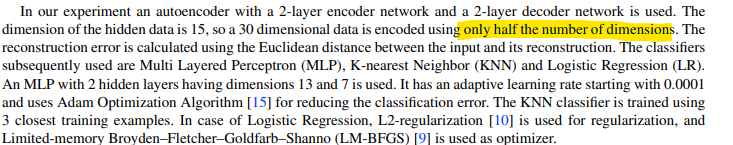

In [22]:
# design arch
in_x = X_scaled_train.shape[1] # จำนวน features -> input_dim
h1 = X_scaled_train.shape[1]//2 #  -> number of neuron in hidden layer 1
h2 = X_scaled_train.shape[1]//4 # -> hidden 2
h3 = X_scaled_train.shape[1]//8 # -> hidden 3

print(f'input layer dim = {in_x}')
print(f'hidden layer dim #1 = {h1}')
print(f'hidden layer dim #2 = {h2}')
print(f'hidden layer dim #3 = {h3}')

input layer dim = 60
hidden layer dim #1 = 30
hidden layer dim #2 = 15
hidden layer dim #3 = 7


In [23]:
from torchinfo import summary
set_seed(42)

model_ae = Autoencoder(input_dim=in_x, 
                         encoding_dim=3, 
                         hidden_layers=[h1, 
                                        h2,
                                        h3,
                                       ],
                         verbose=False
                        )

# This is only used for testing the model architecture, not training or evaluating on real data.
dummy_input = torch.randn(5, X_scaled_train.shape[1]) 
summary(model_ae, input_data=dummy_input, verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [5, 60]                   --
├─Sequential: 1-1                        --                        --
│    └─Linear: 2-1                       [5, 30]                   1,830
│    └─ReLU: 2-2                         [5, 30]                   --
│    └─Linear: 2-3                       [5, 15]                   465
│    └─ReLU: 2-4                         [5, 15]                   --
│    └─Linear: 2-5                       [5, 7]                    112
│    └─ReLU: 2-6                         [5, 7]                    --
│    └─Linear: 2-7                       [5, 3]                    24
├─Sequential: 1-2                        --                        --
│    └─Linear: 2-8                       [5, 7]                    28
│    └─ReLU: 2-9                         [5, 7]                    --
│    └─Linear: 2-10                      [5, 15]                   120
│    └─Re

#### train model to learn normal pattern
It trains an Autoencoder model to reconstruct its input, using mean squared error (MSE) as the loss. 
This lets the model learn the “normal pattern” of your data which you'll later use to detect anomalies.

#### loss  function and optimizer

https://docs.pytorch.org/docs/stable/nn.html#loss-functions

https://medium.com/@chalat.phum/mse-rmse-mae-%E0%B9%80%E0%B8%A5%E0%B8%B7%E0%B8%AD%E0%B8%81%E0%B9%83%E0%B8%8A%E0%B9%89%E0%B8%A2%E0%B8%B1%E0%B8%87%E0%B9%84%E0%B8%87%E0%B8%94%E0%B8%B5%E0%B8%A1%E0%B8%B2%E0%B8%A5%E0%B8%AD%E0%B8%87%E0%B8%94%E0%B8%B9%E0%B8%97%E0%B8%B5%E0%B9%88%E0%B8%84%E0%B8%A7%E0%B8%B2%E0%B8%A1%E0%B8%AB%E0%B8%A1%E0%B8%B2%E0%B8%A2-17b37b0b14b3

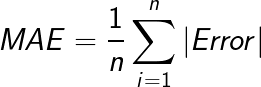

default : MAE เพราะ
1. Robust to Outliers – MAE จะไม่ขยายค่า error ของ outlier ให้มากเกินไปเหมือน MSE (Mean Squared Error) ทำให้ autoencoder ไม่ถูก bias โดยค่าผิดปกติที่รุนแรง ซึ่งเหมาะกับ fraud detection ที่ anomaly มักจะเป็น extreme values

2. Interpretability – ค่าของ MAE ตีความได้ง่ายกว่า เพราะเป็นค่าเฉลี่ยของ absolute difference ระหว่าง input และ reconstruction ทำให้ threshold ในการตัดสิน fraud/non-fraud ดูตรงไปตรงมากว่า

3. Stable Reconstruction Error – MAE ช่วยให้ reconstruction error มีความกระจาย (distribution) ที่ค่อนข้างสม่ำเสมอ ไม่ถูกดันให้ skewed เหมือน MSE ซึ่งจะทำให้การแยกปกติ vs anomaly ด้วย threshold ชัดเจนขึ้น

| **Loss Function**                                          | **When to Use / Pros**                                                                                                     | **PyTorch Implementation**                      |
| ---------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------- |
| **Mean Squared Error (MSE)** (`nn.MSELoss()`)              | Default for continuous features. Penalizes larger errors more. Good when reconstruction of numeric values matters.         | `loss_fn = nn.MSELoss()`                        |
| **Mean Absolute Error (MAE)** (`nn.L1Loss()`)              | More robust to outliers than MSE. Good if anomalies have very large deviations and you don’t want them to dominate.        | `loss_fn = nn.L1Loss()`                         |
| **Huber Loss (Smooth L1)** (`nn.SmoothL1Loss()`)           | A mix of MSE and MAE. Linear for small errors, quadratic for large ones. Balanced robustness.                              | `loss_fn = nn.SmoothL1Loss(beta=1.0)`           |
| **Binary Cross-Entropy (BCE)** (`nn.BCELoss()`)            | Use when inputs are binary or scaled \[0,1]. Common in **image autoencoders (pixel intensity)**.                           | `loss_fn = nn.BCELoss()`                        |
| **BCE with Logits** (`nn.BCEWithLogitsLoss()`)             | Same as BCE but more numerically stable (avoids log(0)). Use if your decoder doesn’t already apply `sigmoid()`.            | `loss_fn = nn.BCEWithLogitsLoss()`              |
| **Kullback-Leibler Divergence (KLDiv)** (`nn.KLDivLoss()`) | Used in **Variational Autoencoders (VAE)** to regularize latent space. Not standalone — combined with reconstruction loss. | `loss_fn = nn.KLDivLoss(reduction="batchmean")` |
| **Cosine Similarity Loss** (`nn.CosineEmbeddingLoss`)      | Useful if you care about *direction* of vectors (embeddings) rather than magnitude.                                        | `loss_fn = nn.CosineEmbeddingLoss()`            |
| **Custom Weighted Loss**                                   | Weight certain features more (e.g., categorical vs numerical).                                                             | `loss = torch.mean(weights * (x - x_hat)**2)`   |


https://docs.pytorch.org/docs/stable/optim.html

default : Adam

| Optimizer                     | Description / When to Use                                                                      |
| ----------------------------- | ---------------------------------------------------------------------------------------------- |
| **Adam** (`optim.Adam`)       | Default choice for autoencoders; adaptive learning rate, generally stable and fast.            |
| **AdamW** (`optim.AdamW`)     | Variant of Adam with better weight decay handling; improves regularization for dense networks. |
| **RMSProp** (`optim.RMSprop`) | Can help stabilize training if gradients are noisy; sometimes useful for deeper autoencoders.  |

In PyTorch, tensors are the main data structure for storing inputs, outputs, and model parameters.
<br>
A device is the hardware that will do computations with these tensors: <br>
CPU: your computer’s main processor. <br>
GPU: a specialized processor for fast parallel computations (much faster for deep learning).
<br>
Every tensor and model must be on the same device for training.

In [24]:
set_seed(42)
trained_model, train_losses, val_losses = train_autoencoder_checkpoint(
    model = model_ae, 
    X_train = X_scaled_train, 
    X_val = X_scaled_val, 
    epochs=20, 
    checkpoint_every=10, 
    early_stopping_patience=10,
    run_dir="model_checkpoint",
    loss_name="mae", 
    optimizer_name="adam",
)

function: train_autoencoder_checkpoint is starting...
[INFO] Using device: cpu
[INFO] Using loss function: L1Loss
[INFO] Using optimizer: Adam
Epoch [1/20] - Train Loss: 0.7959, Val Loss: 0.7887
Epoch [2/20] - Train Loss: 0.7861, Val Loss: 0.7814
Epoch [3/20] - Train Loss: 0.7792, Val Loss: 0.7779
Epoch [4/20] - Train Loss: 0.7770, Val Loss: 0.7780
Epoch [5/20] - Train Loss: 0.7760, Val Loss: 0.7771
Epoch [6/20] - Train Loss: 0.7751, Val Loss: 0.7770
Epoch [7/20] - Train Loss: 0.7745, Val Loss: 0.7770
Epoch [8/20] - Train Loss: 0.7739, Val Loss: 0.7767
Epoch [9/20] - Train Loss: 0.7734, Val Loss: 0.7770
Epoch [10/20] - Train Loss: 0.7729, Val Loss: 0.7768
function: save_checkpoint is starting...
✅ Saved checkpoint: model_checkpoint\20250822_161530\checkpoint_epoch9.pkl
function: save_checkpoint successfully executed at 0.021409034729003906s
Epoch [11/20] - Train Loss: 0.7726, Val Loss: 0.7768
Epoch [12/20] - Train Loss: 0.7722, Val Loss: 0.7766
Epoch [13/20] - Train Loss: 0.7719, Val L

In [28]:
# resume case

# trained_model, train_losses, val_losses = train_autoencoder_checkpoint(
#         model = model_ae, 
#         X_train = X_scaled_train, 
#         X_val = X_scaled_val, 
#         epochs=120, 
#         checkpoint_every=20, 
#         checkpoint_path=r"model_checkpoint\20250814_164332\checkpoint_epoch99.pkl",
#         early_stopping_patience=10,
#         )

In [29]:
# trained_model, train_losses, val_losses, last_epoch = load_pickled_autoencoder(
#     r"model_checkpoint\20250814_164332\checkpoint_epoch99.pkl",
#     model=model_ae,
#     device=torch.device('cpu')
# )

In [30]:
trained_model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=60, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=7, bias=True)
    (5): ReLU()
    (6): Linear(in_features=7, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=60, bias=True)
  )
)

In [31]:
# set_seed(42)
# trained_model , train_losses, val_losses= train_autoencoder(model=model_ae, 
#                                                             X_train=X_scaled_train,
#                                                             X_val = X_scaled_val, 
#                                                             epochs=50, 
#                                                             batch_size=64)

What the graph shows:
- X-axis: Epochs (how many times the model has seen the training data)
- Y-axis: Loss (how well the model reconstructs input — lower is better)

There are two curves:
- Training Loss: Error on the training data the model learned from
- Validation Loss: Error on unseen data (validation set)

Goal: Both losses should decrease and stay close to each other.

If validation loss starts increasing while training loss decreases, it’s a sign to stop training or apply techniques to reduce overfitting.

function: plot_learning_curve is starting...


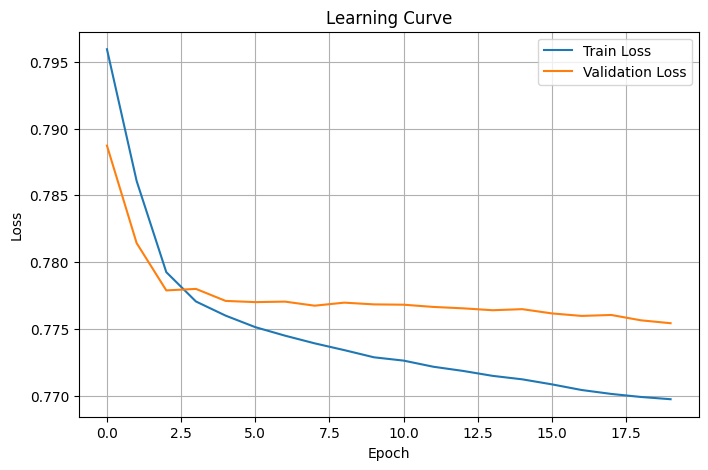

function: plot_learning_curve successfully executed at 0.2649574279785156s


In [25]:
plot_learning_curve(train_losses, val_losses)

### Grid search - skip รันนานเกิน เอาเวลาไปเพิ่ม epoch

| Parameter      | What it controls                  | Why tune it?                         |
| -------------- | --------------------------------- | ------------------------------------ |
| encoding\_dim  | Size of compressed representation | Balance between detail & compression |
| hidden\_layers | Number & size of layers in model  | Model complexity & learning power    |
| activation     | Function deciding neuron output   | How model learns patterns            |
| batch\_size    | Number of samples per update      | Stability & speed of training        |
| lr             | Step size for weight updates      | Training speed & convergence         |


In [32]:
param_grid = {
    "encoding_dim": [2, 3, 4],
    "hidden_layers": [[8], [8, 4], [16, 8]],
    "activation": [nn.ReLU, nn.Tanh],
    "batch_size": [32, 64],
    "lr": [1e-3, 5e-4]
}

## รันนานมาก ขอคอมมเม้นไว้ก่อน
# best_model, best_config, best_val_loss = tune_autoencoder_grid(
#     X_train=X_train,    # your normal train data (numpy or pd.DataFrame)
#     X_val=X_val,        # your normal validation data (numpy or pd.DataFrame)
#     param_grid=param_grid,
#     epochs=50,
#     verbose=True
# )

# print("Best config found:", best_config)

### Predict and Test Performance

- หลังจากได้โมเดล เราลองใส่ X_test เข้าไปเพื่อให้ได้  y_predict
- แล้วทดสอบผลกับ y_test

In [35]:
recon_error = get_reconstruction_error(trained_model, X_scaled_test,loss_name="mae")
recon_error

function: get_reconstruction_error is starting...
[INFO] Reconstruction error calculated using MAE for 2000 samples
[INFO] Error stats -> min: 0.5208, max: 3.4216, mean: 0.8818
function: get_reconstruction_error successfully executed at 0.002811431884765625s


array([0.92456436, 0.8242257 , 0.78521144, ..., 2.9686906 , 0.8111966 ,
       0.7546047 ], shape=(2000,), dtype=float32)

In [36]:
# Pick a threshold (e.g., 95th percentile of normal errors)
threshold = np.percentile(recon_error[y_test == 0], 95)
threshold

np.float32(0.90688384)

In [37]:
# Flag anomalies
y_pred = flag_anomalies(recon_error, threshold)
y_pred

function: flag_anomalies is starting...
function: flag_anomalies successfully executed at 0.00017261505126953125s


array([1, 0, 0, ..., 1, 0, 0], shape=(2000,))

#### [hide] one threshold check

In [36]:
# เราใส่ Testดาต้าทั้งหมด (f / nf) เข้าไปเพื่อเทส (assume ว่าตัวโมเดลเรียนรู้ pattern ความปกติมาแล้ว)
# recon_error, predicted_fraud = detect_anomalies(trained_model, X_test, y_test,threshold_quantile=95)
_, _ = detect_anomalies(trained_model, X_scaled_test, y_test,threshold_quantile=95)

function: detect_anomalies is starting...
Threshold (q=95): 1.2547
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1905
           1       0.50      1.00      0.66        95

    accuracy                           0.95      2000
   macro avg       0.75      0.97      0.82      2000
weighted avg       0.98      0.95      0.96      2000

function: detect_anomalies successfully executed at 0.01280069351196289s


### Embeddings

In [38]:
embeddings = extract_embeddings(trained_model, X_scaled_test)

function: extract_embeddings is starting...
function: extract_embeddings successfully executed at 0.0014405250549316406s


In [37]:
embeddings

array([[-4.0481725 ,  1.9410484 ,  3.1717916 ],
       [-2.877784  , -0.21833037,  1.6486955 ],
       [-2.3774734 , -0.0491026 ,  1.7259252 ],
       ...,
       [-9.17532   , -2.30822   ,  4.303942  ],
       [-1.6483368 , -0.40778032,  1.0351975 ],
       [-3.0401819 , -0.5608417 ,  2.0296023 ]],
      shape=(2000, 3), dtype=float32)

In [38]:
# 1. Only true labels
# plot_latent_space(embeddings, y_test=y_test, encoding_dim=3)

# # 2. Only predicted labels
# plot_latent_space(embeddings, y_pred=predicted_fraud, encoding_dim=3)

# # 3. Compare both
# plot_latent_space(embeddings, y_test=y_test, y_pred=y_pred, encoding_dim=3)

function: plot_latent_space_2d is starting...


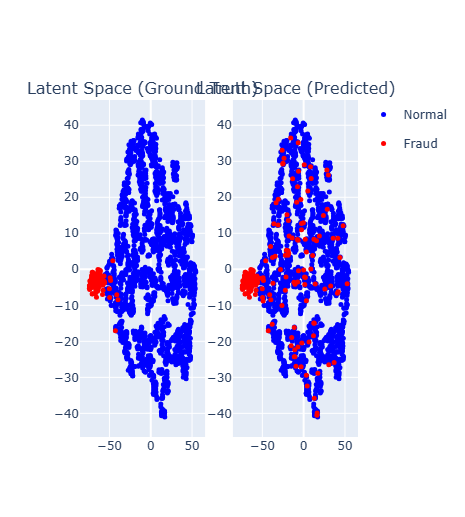

function: plot_latent_space_2d successfully executed at 9.439443349838257s


In [39]:
plot_latent_space_2d(
    embeddings=embeddings,
    y_test=y_test,
    y_pred=y_pred,
    index_df=test_df,        # DataFrame to use for hover info
    hover_col='sales_id'     # column in test_df to display on hover
)

In [40]:
plot_latent_space_3d(
    embeddings=embeddings,
    y_test=y_test,
    y_pred=y_pred,
    index_df=test_df,        # DataFrame to use for hover info
    hover_col='sales_id'     # column in test_df to display on hover
)

function: plot_latent_space_3d is starting...


function: plot_latent_space_3d successfully executed at 0.1478579044342041s


In [53]:
pd.DataFrame({
    "y_test": pd.Series(y_test).value_counts(),
    "y_pred": pd.Series(y_pred).value_counts()
}).fillna(0).astype(int)

,y_test,y_pred
0,1905,1809
1,95,191


### Packing

In [41]:
df_lables = create_pack_results(test_df, y_pred, experiment_name='ae_all_1')
df_lables = df_lables.set_index('sales_id')
df_lables

function: create_pack_results is starting...
function: create_pack_results successfully executed at 0.0013988018035888672s


,ae_all_1
sales_id,
8751,1
3108,0
7395,0
1373,0
1858,0
...,...
3178,0
9980,0
1440,1


In [45]:
# # First experiment
# results_df = create_results_df_wide(test_df, y_pred_ae1, experiment_name='ae_1')

# # Second experiment
# results_df = append_experiment_results(results_df, y_pred_ae2, experiment_name='ae_2')

# # Third experiment
# results_df = append_experiment_results(results_df, y_pred_ae3, experiment_name='ae_3')

# results_df

In [55]:
res_1 = evaluate_thresholds(x_scaled = X_scaled_test , 
                    test_df=test_df ,
                    y_test=y_test , 
                    recon_error=recon_error ,
                    true_fraud_list=true_fraud_list)

function: evaluate_thresholds is starting...
function: flag_anomalies is starting...
function: flag_anomalies successfully executed at 0.001295328140258789s
function: create_pack_results is starting...
function: create_pack_results successfully executed at 0.0023946762084960938s
function: flag_anomalies is starting...
function: flag_anomalies successfully executed at 0.0010523796081542969s
function: create_pack_results is starting...
function: create_pack_results successfully executed at 0.0013384819030761719s
function: flag_anomalies is starting...
function: flag_anomalies successfully executed at 0.0006008148193359375s
function: create_pack_results is starting...
function: create_pack_results successfully executed at 0.0005927085876464844s
function: flag_anomalies is starting...
function: flag_anomalies successfully executed at 0.0004646778106689453s
function: create_pack_results is starting...
function: create_pack_results successfully executed at 0.0005686283111572266s
function: fl

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 76.00it/s]


function: evaluate_fraud_predictions successfully executed at 0.18122482299804688s
function: evaluate_thresholds successfully executed at 0.24078369140625s


In [56]:
res_1

,experiments,total_alert,tp,fp,tn,fn,precision,recall,f0.5,f1
0,ae_default_all_p10,1809,95,1714,191,0,0.052515,1.0,0.064793,0.099790
1,ae_default_all_p20,1619,95,1524,381,0,0.058678,1.0,0.072287,0.110852
2,ae_default_all_p30,1428,95,1333,572,0,0.066527,1.0,0.081798,0.124754
3,ae_default_all_p40,1238,95,1143,762,0,0.076737,1.0,0.094115,0.142536
4,ae_default_all_p50,1047,95,952,953,0,0.090735,1.0,0.110904,0.166375
5,ae_default_all_p60,857,95,762,1143,0,0.110852,1.0,0.134828,0.199580
6,ae_default_all_p70,667,95,572,1333,0,0.142429,1.0,0.171915,0.249344
7,ae_default_all_p80,476,95,381,1524,0,0.199580,1.0,0.237619,0.332750
8,ae_default_all_p85,381,95,286,1619,0,0.249344,1.0,0.293391,0.399160
9,ae_default_all_p90,286,95,191,1714,0,0.332168,1.0,0.383374,0.498688


# Pipeline

In [21]:
# design arch
in_x = X_scaled_train.shape[1] # จำนวน features -> input_dim
h1 = X_scaled_train.shape[1]//2 #  -> number of neuron in hidden layer 1
h2 = X_scaled_train.shape[1]//4 # -> hidden 2
h3 = X_scaled_train.shape[1]//8 # -> hidden 3

print(f'input layer dim = {in_x}')
print(f'hidden layer dim #1 = {h1}')
print(f'hidden layer dim #2 = {h2}')
print(f'hidden layer dim #3 = {h3}')

input layer dim = 60
hidden layer dim #1 = 30
hidden layer dim #2 = 15
hidden layer dim #3 = 7


In [22]:
from torchinfo import summary
set_seed(42)

model_ae = Autoencoder(input_dim=in_x, 
                         encoding_dim=3, 
                         hidden_layers=[h1, 
                                        h2,
                                        h3,
                                       ],
                         verbose=False
                        )

# This is only used for testing the model architecture, not training or evaluating on real data.
dummy_input = torch.randn(5, X_scaled_train.shape[1]) 
summary(model_ae, input_data=dummy_input, verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [5, 60]                   --
├─Sequential: 1-1                        --                        --
│    └─Linear: 2-1                       [5, 30]                   1,830
│    └─ReLU: 2-2                         [5, 30]                   --
│    └─Linear: 2-3                       [5, 15]                   465
│    └─ReLU: 2-4                         [5, 15]                   --
│    └─Linear: 2-5                       [5, 7]                    112
│    └─ReLU: 2-6                         [5, 7]                    --
│    └─Linear: 2-7                       [5, 3]                    24
├─Sequential: 1-2                        --                        --
│    └─Linear: 2-8                       [5, 7]                    28
│    └─ReLU: 2-9                         [5, 7]                    --
│    └─Linear: 2-10                      [5, 15]                   120
│    └─Re

function: run_training_pipeline is starting...
function: train_autoencoder_checkpoint is starting...
[INFO] Using device: cpu
[INFO] Using loss function: L1Loss
[INFO] Using optimizer: Adam
Epoch [1/20] - Train Loss: 0.7959, Val Loss: 0.7887
Epoch [2/20] - Train Loss: 0.7861, Val Loss: 0.7814
Epoch [3/20] - Train Loss: 0.7792, Val Loss: 0.7779
Epoch [4/20] - Train Loss: 0.7770, Val Loss: 0.7780
Epoch [5/20] - Train Loss: 0.7760, Val Loss: 0.7771
Epoch [6/20] - Train Loss: 0.7751, Val Loss: 0.7770
Epoch [7/20] - Train Loss: 0.7745, Val Loss: 0.7770
Epoch [8/20] - Train Loss: 0.7739, Val Loss: 0.7767
Epoch [9/20] - Train Loss: 0.7734, Val Loss: 0.7770
Epoch [10/20] - Train Loss: 0.7729, Val Loss: 0.7768
function: save_checkpoint is starting...
✅ Saved checkpoint: model_checkpoint\20250822_164012\checkpoint_epoch9.pkl
function: save_checkpoint successfully executed at 0.017268657684326172s
Epoch [11/20] - Train Loss: 0.7726, Val Loss: 0.7768
Epoch [12/20] - Train Loss: 0.7722, Val Loss: 0

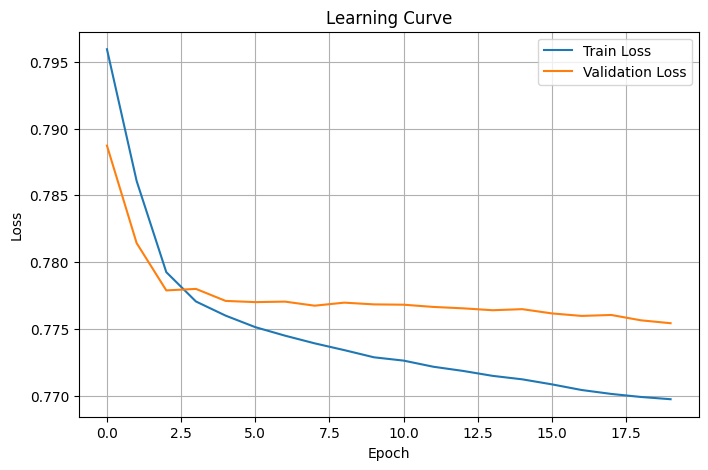

function: plot_learning_curve successfully executed at 0.1990664005279541s
function: create_pack_results is starting...
function: create_pack_results successfully executed at 0.0006511211395263672s
function: get_reconstruction_error is starting...
[INFO] Reconstruction error calculated using MAE for 2000 samples
[INFO] Error stats -> min: 0.5208, max: 3.4216, mean: 0.8818
function: get_reconstruction_error successfully executed at 0.006740570068359375s
function: evaluate_thresholds is starting...
function: flag_anomalies is starting...
function: flag_anomalies successfully executed at 7.748603820800781e-05s
function: create_pack_results is starting...
function: create_pack_results successfully executed at 0.00035071372985839844s
function: flag_anomalies is starting...
function: flag_anomalies successfully executed at 0.00015997886657714844s
function: create_pack_results is starting...
function: create_pack_results successfully executed at 0.00040268898010253906s
function: flag_anomalie

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 85.72it/s]

function: evaluate_fraud_predictions successfully executed at 0.15700221061706543s
function: evaluate_thresholds successfully executed at 0.1749558448791504s
function: run_training_pipeline successfully executed at 14.547675371170044s
function: run_threshold_and_plot_pipeline is starting...
function: get_reconstruction_error is starting...
[INFO] Reconstruction error calculated using MSE for 2000 samples
[INFO] Error stats -> min: 0.4494, max: 14.7405, mean: 1.4660
function: get_reconstruction_error successfully executed at 0.0024297237396240234s
Selected threshold (95 percentile): 1.2547
function: flag_anomalies is starting...
function: flag_anomalies successfully executed at 5.936622619628906e-05s
function: extract_embeddings is starting...
[INFO] Using device: cpu
[INFO] Input shape: torch.Size([2000, 60])
[INFO] Extracted embeddings shape: (2000, 3)
function: extract_embeddings successfully executed at 0.0025892257690429688s
function: plot_latent_space_2d is starting...


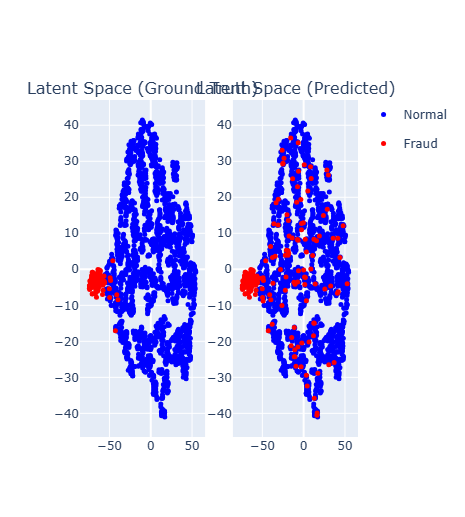

function: plot_latent_space_2d successfully executed at 9.882104635238647s
function: plot_latent_space_3d is starting...


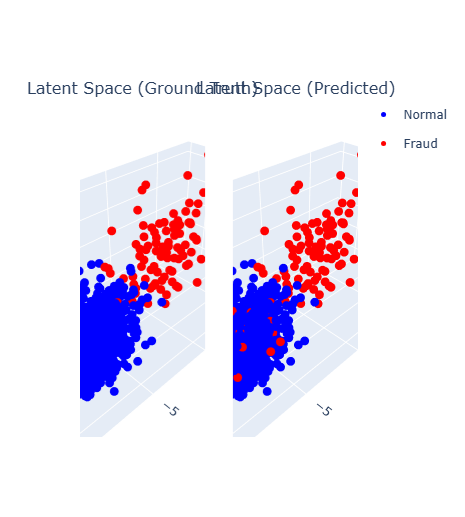

function: plot_latent_space_3d successfully executed at 0.15144062042236328s
function: run_threshold_and_plot_pipeline successfully executed at 10.047672510147095s


In [23]:
# Step 1: Train and evaluate
trained_model, train_losses, val_losses, df_lables, res_thresholds = run_training_pipeline(
    model=model_ae,
    X_scaled_train=X_scaled_train,
    X_scaled_val=X_scaled_val,
    X_scaled_test=X_scaled_test,
    test_df=test_df,
    y_test=y_test,
    true_fraud_list=true_fraud_list,
    seed= 42,
    epochs = 20,
    checkpoint_every= 10,
    early_stopping_patience = 10,
    run_dir= "model_checkpoint",
    loss_name= "mae",
    optimizer_name = "adam"
)

# Step 2: Manual threshold selection & latent space plots
recon_error, threshold, y_pred, embeddings = run_threshold_and_plot_pipeline(
    trained_model=trained_model,
    X_scaled_test=X_scaled_test,
    test_df=test_df,
    y_test=y_test,
    threshold_percentile=95,
    hover_col='sales_id'
)


In [24]:
res_thresholds

,experiments,total_alert,tp,fp,tn,fn,precision,recall,f0.5,f1
0,ae_default_all_p10,1809,95,1714,191,0,0.052515,1.0,0.064793,0.099790
1,ae_default_all_p20,1619,95,1524,381,0,0.058678,1.0,0.072287,0.110852
2,ae_default_all_p30,1428,95,1333,572,0,0.066527,1.0,0.081798,0.124754
3,ae_default_all_p40,1238,95,1143,762,0,0.076737,1.0,0.094115,0.142536
4,ae_default_all_p50,1047,95,952,953,0,0.090735,1.0,0.110904,0.166375
5,ae_default_all_p60,857,95,762,1143,0,0.110852,1.0,0.134828,0.199580
6,ae_default_all_p70,667,95,572,1333,0,0.142429,1.0,0.171915,0.249344
7,ae_default_all_p80,476,95,381,1524,0,0.199580,1.0,0.237619,0.332750
8,ae_default_all_p85,381,95,286,1619,0,0.249344,1.0,0.293391,0.399160
9,ae_default_all_p90,286,95,191,1714,0,0.332168,1.0,0.383374,0.498688


# [13-08-2025] ตัด label ว่า แล้วตัวที่ predict (แดง) อยู่่ใน่ กลุ่มก้อน 
หา overlap ว่าเกิดเท่าไหร่ 
มิติเล็กลงเห็นไร

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler

# def cluster_embeddings(embeddings, sales_ids=None, labels=None, eps=0.5, min_samples=5):
#     """
#     Cluster 3D embeddings using DBSCAN and visualize results.
    
#     Parameters:
#     - embeddings: np.ndarray (n_samples, 3)
#     - sales_ids: list or array of IDs (optional)
#     - labels: list or array of fraud labels (optional)
#     - eps: DBSCAN eps parameter
#     - min_samples: DBSCAN min_samples parameter
    
#     Returns:
#     - DataFrame with sales_id, cluster_id, and label (if provided)
#     """
    
#     # Standardize embeddings for DBSCAN
#     embeddings_scaled = StandardScaler().fit_transform(embeddings)
    
#     # Run DBSCAN
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     cluster_ids = dbscan.fit_predict(embeddings_scaled)
    
#     # Prepare results DataFrame
#     df = pd.DataFrame({
#         "sales_id": sales_ids if sales_ids is not None else np.arange(len(embeddings)),
#         "cluster_id": cluster_ids
#     })
    
#     if labels is not None:
#         df["label"] = labels
    
#     # Plot results
#     fig = plt.figure(figsize=(14, 6))
    
#     ax1 = fig.add_subplot(121, projection='3d')
#     scatter1 = ax1.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2],
#                            c=cluster_ids, cmap='tab10', s=20)
#     ax1.set_title("Clusters (DBSCAN)")
#     plt.colorbar(scatter1, ax=ax1, label="Cluster ID")
    
#     ax2 = fig.add_subplot(122, projection='3d')
#     if labels is not None:
#         scatter2 = ax2.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2],
#                                c=labels, cmap='coolwarm', s=20)
#         ax2.set_title("Fraud vs Normal")
#         plt.colorbar(scatter2, ax=ax2, label="Label (0=Normal, 1=Fraud)")
#     else:
#         ax2.set_title("No Labels Provided")
    
#     plt.show()
    
#     return df


In [ ]:
# df_clusters = cluster_embeddings(
#     embeddings=embeddings,
#     sales_ids=np.arange(len(embeddings)),
#     labels=np.random.randint(0, 2, size=embeddings.shape[0]),  # Replace with your real labels
#     eps=0.5,
#     min_samples=5
# )
# df_clusters

# [13-08-2025] อยากให้ลองทำทั้ง novelty , anomaly and supervised (เอาคนที่เรา predict จาก novelty/anomaly ไปเป็น label)